In [11]:
import sys
import os
import pandas as pd
# Add the root folder of your project
root_path = os.path.abspath(os.path.join("..", ".."))  # two levels up from experiments
sys.path.append(root_path)
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import pickle
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


from weather_classification.weather_dataset import WeatherDataset
from weather_classification.predict import predict
from weather_classification.modeling.cnn import CNN_V3_reg_v2
from weather_classification.seed_utils import set_seed
set_seed(1234)

import torch

In [4]:
def train_model_improved(model_class, train_dir, val_dir, input_dim, num_classes=11, 
                batch_size=32, epochs=20, lr=1e-3, device="cuda", optimizer="Adam",
                use_scheduler=True, label_smoothing=0.1, p_conv=None, p_fc=None):
    
    model_name = "CNN_V3_reg_v2"

    PROJECT_ROOT = os.getcwd()

    metrics_dir = os.path.join(PROJECT_ROOT, "reports", "metrics")
    models_dir = os.path.join(PROJECT_ROOT, "models")

    os.makedirs(metrics_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    # --- Include grid search params (e.g., dropout rates) in file names ---
    if p_conv is not None and p_fc is not None:
        metrics_path = os.path.join(
            metrics_dir, f"metrics_{model_name}_{optimizer}_{p_conv}_{p_fc}.pkl"
        )
        model_path = os.path.join(
            models_dir, f"best_model_{model_name}_{optimizer}_{p_conv}_{p_fc}.pth"
        )


    mean = [0.5167, 0.5143, 0.5164]
    std = [0.2378, 0.2359, 0.2393]

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),  
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


    # Datasets with different transforms for train/val
    train_dataset = WeatherDataset(train_dir, transform=train_transform)
    val_dataset = WeatherDataset(val_dir, transform=val_transform)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=4, pin_memory=True)

    # Calculate weights per class
    labels = [label for _, label in train_dataset.samples]
    class_counts = Counter(labels)
    num_classes = len(class_counts)

    total_samples = sum(class_counts.values())
    class_weights = [total_samples / class_counts[i] for i in range(num_classes)]
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    print("Class counts:", class_counts)
    print("Class weights:", {i: f"{w:.3f}" for i, w in enumerate(class_weights)})

    # Model
    model = model_class(input_dim=input_dim, num_classes=num_classes).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel: {model_name}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}\n")

    # Loss with label smoothing to prevent overconfidence
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)
    
    # Optimizer: AdamW with weight decay
    if optimizer == "Adam":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optimizer == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)

    
    # Learning rate scheduler - CRITICAL for convergence
    if use_scheduler:
        # ReduceLROnPlateau: reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
        )
        # Alternative: CosineAnnealingLR for smoother decay
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 7  # Stop if no improvement for 7 epochs
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            preds = outputs.argmax(1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                preds = outputs.argmax(1)
                val_loss += loss.item() * imgs.size(0)
                val_corrects += (preds == labels).sum().item()

        val_loss /= len(val_dataset)
        val_acc = val_corrects / len(val_dataset)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        if use_scheduler:
            scheduler.step(val_loss)  # For ReduceLROnPlateau
            # scheduler.step()  # For CosineAnnealingLR

        # Save metrics
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
              f"LR={current_lr:.6f}")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"✓ Best model saved in {model_path} (val_acc={val_acc:.4f})")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            print(f"No improvement for {early_stop_patience} consecutive epochs")
            break

    # Save metrics to .pkl
    with open(metrics_path, "wb") as f:
        pickle.dump(history, f)

    print(f"\nTraining complete!")
    print(f"Best val_acc: {best_val_acc:.4f}")
    print(f"Best val_loss: {best_val_loss:.4f}")
    print(f"Metrics saved in {metrics_path}")
    print(f"Model saved in {model_path}")
    
    return model, history

In [ ]:
input_dim = 224*224*3  # matches the Resize transform
optimizers = ["Adam", "Momentum", "RMSprop"]
results_optimizer = {}

for opt in optimizers:
    print(f"\n===== Training with optimizer: {opt} =====\n")
    
    model, history = train_model_improved(
        model_class=CNN_V3_reg_v2,
        train_dir="../../data/train",
        val_dir="../../data/val",
        input_dim=input_dim,
        num_classes=11,
        batch_size=64,
        epochs=20,
        lr=1e-3,
        device="cuda" if torch.cuda.is_available() else "cpu",
        optimizer=opt
    )
    
    results_optimizer[opt] = {
        "best_val_acc": max(history["val_acc"]),
        "history": history
    }

# Optional: print summary
print("\n===== Optimizer Grid Search Results =====")
for opt, res in results_optimizer.items():
    print(f"{opt}: Best val_acc = {res['best_val_acc']:.4f}")


===== Training with optimizer: Adam =====

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_V3_reg_v2
Total parameters: 6,981,035
Trainable parameters: 6,981,035



Epoch 1/20 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


Epoch 1/20: Train Loss=2.2384, Train Acc=0.2225, Val Loss=2.0721, Val Acc=0.3446, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.3446)


Epoch 2/20 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


Epoch 2/20: Train Loss=1.8961, Train Acc=0.4260, Val Loss=1.8223, Val Acc=0.5279, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.5279)


Epoch 3/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 3/20: Train Loss=1.7258, Train Acc=0.5237, Val Loss=1.6733, Val Acc=0.6056, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.6056)


Epoch 4/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


Epoch 4/20: Train Loss=1.6274, Train Acc=0.5600, Val Loss=1.6480, Val Acc=0.5968, LR=0.001000


Epoch 5/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 5/20: Train Loss=1.5596, Train Acc=0.6001, Val Loss=1.5494, Val Acc=0.6364, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.6364)


Epoch 6/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Epoch 6/20: Train Loss=1.4929, Train Acc=0.6233, Val Loss=1.5821, Val Acc=0.6657, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.6657)


Epoch 7/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


Epoch 7/20: Train Loss=1.4748, Train Acc=0.6357, Val Loss=1.5802, Val Acc=0.6393, LR=0.001000


Epoch 8/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Epoch 8/20: Train Loss=1.4529, Train Acc=0.6431, Val Loss=1.4789, Val Acc=0.6906, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.6906)


Epoch 9/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


Epoch 9/20: Train Loss=1.3847, Train Acc=0.6792, Val Loss=1.4314, Val Acc=0.6686, LR=0.001000


Epoch 10/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.22it/s]


Epoch 10/20: Train Loss=1.3526, Train Acc=0.6875, Val Loss=1.4252, Val Acc=0.7023, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.7023)


Epoch 11/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


Epoch 11/20: Train Loss=1.3307, Train Acc=0.6962, Val Loss=1.3819, Val Acc=0.7199, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.7199)


Epoch 12/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Epoch 12/20: Train Loss=1.2968, Train Acc=0.7130, Val Loss=1.3941, Val Acc=0.6965, LR=0.001000


Epoch 13/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


Epoch 13/20: Train Loss=1.2651, Train Acc=0.7323, Val Loss=1.3514, Val Acc=0.7097, LR=0.001000


Epoch 14/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Epoch 14/20: Train Loss=1.2482, Train Acc=0.7365, Val Loss=1.3484, Val Acc=0.7053, LR=0.001000


Epoch 15/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


Epoch 15/20: Train Loss=1.2109, Train Acc=0.7553, Val Loss=1.3299, Val Acc=0.7258, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.7258)


Epoch 16/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.22it/s]


Epoch 16/20: Train Loss=1.1821, Train Acc=0.7631, Val Loss=1.3108, Val Acc=0.7493, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.7493)


Epoch 17/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


Epoch 17/20: Train Loss=1.1326, Train Acc=0.7826, Val Loss=1.2680, Val Acc=0.7317, LR=0.001000


Epoch 18/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Epoch 18/20: Train Loss=1.1167, Train Acc=0.7941, Val Loss=1.2370, Val Acc=0.7683, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth (val_acc=0.7683)


Epoch 19/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Epoch 19/20: Train Loss=1.0974, Train Acc=0.8063, Val Loss=1.2655, Val Acc=0.7390, LR=0.001000


Epoch 20/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Epoch 20/20: Train Loss=1.0544, Train Acc=0.8268, Val Loss=1.2204, Val Acc=0.7654, LR=0.001000

Training complete!
Best val_acc: 0.7683
Best val_loss: 1.2370
Metrics saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\reports\metrics\metrics_CNN_V3_reg_v2_Adam.pkl
Model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam.pth

===== Training with optimizer: Momentum =====

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_V3_reg_v2
Total parameters: 6,981,035
Trainable parameters: 6,981,035



Epoch 1/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 1/20: Train Loss=2.4411, Train Acc=0.0830, Val Loss=2.4659, Val Acc=0.0880, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.0880)


Epoch 2/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 2/20: Train Loss=2.4391, Train Acc=0.0857, Val Loss=2.4650, Val Acc=0.0689, LR=0.001000


Epoch 3/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 3/20: Train Loss=2.4362, Train Acc=0.0770, Val Loss=2.4632, Val Acc=0.0733, LR=0.001000


Epoch 4/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 4/20: Train Loss=2.4321, Train Acc=0.0804, Val Loss=2.4580, Val Acc=0.0850, LR=0.001000


Epoch 5/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 5/20: Train Loss=2.4180, Train Acc=0.0879, Val Loss=2.4395, Val Acc=0.0953, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.0953)


Epoch 6/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 6/20: Train Loss=2.3860, Train Acc=0.1492, Val Loss=2.3998, Val Acc=0.2258, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.2258)


Epoch 7/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


Epoch 7/20: Train Loss=2.3594, Train Acc=0.1997, Val Loss=2.3681, Val Acc=0.2654, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.2654)


Epoch 8/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.22it/s]


Epoch 8/20: Train Loss=2.3319, Train Acc=0.2319, Val Loss=2.3489, Val Acc=0.3006, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3006)


Epoch 9/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


Epoch 9/20: Train Loss=2.3099, Train Acc=0.2505, Val Loss=2.3267, Val Acc=0.3255, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3255)


Epoch 10/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


Epoch 10/20: Train Loss=2.2776, Train Acc=0.2695, Val Loss=2.2971, Val Acc=0.3065, LR=0.001000


Epoch 11/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


Epoch 11/20: Train Loss=2.2546, Train Acc=0.2728, Val Loss=2.2784, Val Acc=0.3123, LR=0.001000


Epoch 12/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 12/20: Train Loss=2.2170, Train Acc=0.2903, Val Loss=2.2391, Val Acc=0.3358, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3358)


Epoch 13/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 13/20: Train Loss=2.1972, Train Acc=0.2914, Val Loss=2.2213, Val Acc=0.3343, LR=0.001000


Epoch 14/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 14/20: Train Loss=2.1790, Train Acc=0.2983, Val Loss=2.1971, Val Acc=0.3592, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3592)


Epoch 15/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 15/20: Train Loss=2.1571, Train Acc=0.3076, Val Loss=2.1827, Val Acc=0.3548, LR=0.001000


Epoch 16/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 16/20: Train Loss=2.1402, Train Acc=0.3224, Val Loss=2.1726, Val Acc=0.3666, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3666)


Epoch 17/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 17/20: Train Loss=2.1277, Train Acc=0.3306, Val Loss=2.1557, Val Acc=0.3812, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3812)


Epoch 18/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 18/20: Train Loss=2.1154, Train Acc=0.3313, Val Loss=2.1534, Val Acc=0.3827, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.3827)


Epoch 19/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


Epoch 19/20: Train Loss=2.1002, Train Acc=0.3466, Val Loss=2.1371, Val Acc=0.4003, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.4003)


Epoch 20/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


Epoch 20/20: Train Loss=2.0958, Train Acc=0.3425, Val Loss=2.1346, Val Acc=0.4032, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth (val_acc=0.4032)

Training complete!
Best val_acc: 0.4032
Best val_loss: 2.1346
Metrics saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\reports\metrics\metrics_CNN_V3_reg_v2_Momentum.pkl
Model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Momentum.pth

===== Training with optimizer: RMSprop =====

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_V3_reg_v2
Total paramet

Epoch 1/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 1/20: Train Loss=2.2410, Train Acc=0.2657, Val Loss=1.9297, Val Acc=0.4399, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.4399)


Epoch 2/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 2/20: Train Loss=1.8546, Train Acc=0.4508, Val Loss=1.7765, Val Acc=0.5440, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.5440)


Epoch 3/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


Epoch 3/20: Train Loss=1.6878, Train Acc=0.5399, Val Loss=1.5735, Val Acc=0.6129, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.6129)


Epoch 4/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 4/20: Train Loss=1.5755, Train Acc=0.5965, Val Loss=1.5556, Val Acc=0.6525, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.6525)


Epoch 5/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Epoch 5/20: Train Loss=1.5128, Train Acc=0.6165, Val Loss=1.5364, Val Acc=0.6730, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.6730)


Epoch 6/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


Epoch 6/20: Train Loss=1.4478, Train Acc=0.6490, Val Loss=1.5649, Val Acc=0.6598, LR=0.001000


Epoch 7/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


Epoch 7/20: Train Loss=1.3952, Train Acc=0.6721, Val Loss=1.4261, Val Acc=0.6906, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.6906)


Epoch 8/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 8/20: Train Loss=1.3493, Train Acc=0.6955, Val Loss=1.4508, Val Acc=0.6246, LR=0.001000


Epoch 9/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 9/20: Train Loss=1.2993, Train Acc=0.7148, Val Loss=1.3896, Val Acc=0.6950, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.6950)


Epoch 10/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 10/20: Train Loss=1.2697, Train Acc=0.7323, Val Loss=1.3072, Val Acc=0.7229, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.7229)


Epoch 11/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 11/20: Train Loss=1.2138, Train Acc=0.7495, Val Loss=1.3039, Val Acc=0.7229, LR=0.001000


Epoch 12/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch 12/20: Train Loss=1.1845, Train Acc=0.7604, Val Loss=1.2483, Val Acc=0.7507, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.7507)


Epoch 13/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Epoch 13/20: Train Loss=1.1441, Train Acc=0.7837, Val Loss=1.2485, Val Acc=0.7757, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.7757)


Epoch 14/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


Epoch 14/20: Train Loss=1.1126, Train Acc=0.7961, Val Loss=1.2160, Val Acc=0.7625, LR=0.001000


Epoch 15/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Epoch 15/20: Train Loss=1.0765, Train Acc=0.8142, Val Loss=1.1978, Val Acc=0.7625, LR=0.001000


Epoch 16/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


Epoch 16/20: Train Loss=1.0480, Train Acc=0.8259, Val Loss=1.2392, Val Acc=0.7625, LR=0.001000


Epoch 17/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 17/20: Train Loss=1.0002, Train Acc=0.8497, Val Loss=1.2480, Val Acc=0.7405, LR=0.001000


Epoch 18/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


Epoch 18/20: Train Loss=0.9851, Train Acc=0.8550, Val Loss=1.1813, Val Acc=0.7830, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth (val_acc=0.7830)


Epoch 19/20 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


Epoch 19/20: Train Loss=0.9531, Train Acc=0.8638, Val Loss=1.1844, Val Acc=0.7610, LR=0.001000


Epoch 20/20 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]

Epoch 20/20: Train Loss=0.9316, Train Acc=0.8747, Val Loss=1.1905, Val Acc=0.7801, LR=0.001000

Training complete!
Best val_acc: 0.7830
Best val_loss: 1.1813
Metrics saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\reports\metrics\metrics_CNN_V3_reg_v2_RMSprop.pkl
Model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_RMSprop.pth

===== Optimizer Grid Search Results =====
Adam: Best val_acc = 0.7683
Momentum: Best val_acc = 0.4032
RMSprop: Best val_acc = 0.7830


In [6]:
input_dim = 224*224*3  # matches the Resize transform
reg_params = [
    {"p_conv": 0.1, "p_fc": 0.3},
    {"p_conv": 0.15, "p_fc": 0.4},
    {"p_conv": 0.2, "p_fc": 0.5},
]

results_reg = {}

for params in reg_params:
    print(f"\n===== Training with p_conv={params['p_conv']}, p_fc={params['p_fc']} =====\n")
    
    # Use lambda to pass dropout params to constructor
    model_class = partial(
        CNN_V3_reg_v2,
        p_conv=params["p_conv"],
        p_fc=params["p_fc"]
    )
    
    model, history = train_model_improved(
        model_class=model_class,
        train_dir="../../data/train",
        val_dir="../../data/val",
        input_dim=input_dim,
        num_classes=11,
        batch_size=64,
        epochs=25,
        lr=1e-3,
        device="cuda" if torch.cuda.is_available() else "cpu",
        optimizer="Adam",
        p_conv=params["p_conv"],
        p_fc=params["p_fc"]
    )
    
    results_reg[(params["p_conv"], params["p_fc"])] = {
        "best_val_acc": max(history["val_acc"]),
        "history": history
    }

# Optional: print summary
print("\n===== Regularization Grid Search Results =====")
for (p_conv, p_fc), res in results_reg.items():
    print(f"p_conv={p_conv}, p_fc={p_fc}: Best val_acc = {res['best_val_acc']:.4f}")


===== Training with p_conv=0.1, p_fc=0.3 =====

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_V3_reg_v2
Total parameters: 6,981,035
Trainable parameters: 6,981,035



Epoch 1/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 1/25: Train Loss=2.1603, Train Acc=0.2788, Val Loss=1.9045, Val Acc=0.4194, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.4194)


Epoch 2/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 2/25: Train Loss=1.7443, Train Acc=0.4739, Val Loss=1.7874, Val Acc=0.4971, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.4971)


Epoch 3/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 3/25: Train Loss=1.6226, Train Acc=0.5538, Val Loss=1.5388, Val Acc=0.6290, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.6290)


Epoch 4/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 4/25: Train Loss=1.5281, Train Acc=0.6045, Val Loss=1.5048, Val Acc=0.6496, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.6496)


Epoch 5/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 5/25: Train Loss=1.4598, Train Acc=0.6304, Val Loss=1.4275, Val Acc=0.6935, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.6935)


Epoch 6/25 [Val]: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Epoch 6/25: Train Loss=1.4123, Train Acc=0.6526, Val Loss=1.5393, Val Acc=0.6466, LR=0.001000


Epoch 7/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch 7/25: Train Loss=1.3929, Train Acc=0.6720, Val Loss=1.4551, Val Acc=0.6994, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.6994)


Epoch 8/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 8/25: Train Loss=1.3354, Train Acc=0.6847, Val Loss=1.3613, Val Acc=0.6935, LR=0.001000


Epoch 9/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 9/25: Train Loss=1.3005, Train Acc=0.7000, Val Loss=1.4238, Val Acc=0.6686, LR=0.001000


Epoch 10/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 10/25: Train Loss=1.2675, Train Acc=0.7228, Val Loss=1.3127, Val Acc=0.6994, LR=0.001000


Epoch 11/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 11/25: Train Loss=1.2218, Train Acc=0.7354, Val Loss=1.3060, Val Acc=0.7141, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7141)


Epoch 12/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 12/25: Train Loss=1.1921, Train Acc=0.7555, Val Loss=1.3436, Val Acc=0.7053, LR=0.001000


Epoch 13/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 13/25: Train Loss=1.1419, Train Acc=0.7746, Val Loss=1.2940, Val Acc=0.7214, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7214)


Epoch 14/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


Epoch 14/25: Train Loss=1.1261, Train Acc=0.7779, Val Loss=1.2647, Val Acc=0.7581, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7581)


Epoch 15/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 15/25: Train Loss=1.0707, Train Acc=0.8067, Val Loss=1.2235, Val Acc=0.7537, LR=0.001000


Epoch 16/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 16/25: Train Loss=1.0374, Train Acc=0.8213, Val Loss=1.2062, Val Acc=0.7449, LR=0.001000


Epoch 17/25 [Val]: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


Epoch 17/25: Train Loss=0.9960, Train Acc=0.8421, Val Loss=1.2282, Val Acc=0.7551, LR=0.001000


Epoch 18/25 [Val]: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Epoch 18/25: Train Loss=0.9632, Train Acc=0.8558, Val Loss=1.2743, Val Acc=0.7229, LR=0.001000


Epoch 19/25 [Val]: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Epoch 19/25: Train Loss=0.9369, Train Acc=0.8671, Val Loss=1.1804, Val Acc=0.7639, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7639)


Epoch 20/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Epoch 20/25: Train Loss=0.9008, Train Acc=0.8838, Val Loss=1.2299, Val Acc=0.7287, LR=0.001000


Epoch 21/25 [Val]: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


Epoch 21/25: Train Loss=0.8733, Train Acc=0.9001, Val Loss=1.2066, Val Acc=0.7713, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7713)


Epoch 22/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 22/25: Train Loss=0.8506, Train Acc=0.9032, Val Loss=1.1981, Val Acc=0.7698, LR=0.001000


Epoch 23/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Epoch 23/25: Train Loss=0.8311, Train Acc=0.9132, Val Loss=1.1706, Val Acc=0.7727, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7727)


Epoch 24/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 24/25: Train Loss=0.8108, Train Acc=0.9247, Val Loss=1.2122, Val Acc=0.7683, LR=0.001000


Epoch 25/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 25/25: Train Loss=0.7856, Train Acc=0.9294, Val Loss=1.1589, Val Acc=0.7742, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth (val_acc=0.7742)

Training complete!
Best val_acc: 0.7742
Best val_loss: 1.1589
Metrics saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\reports\metrics\metrics_CNN_V3_reg_v2_Adam_0.1_0.3.pkl
Model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth

===== Training with p_conv=0.15, p_fc=0.4 =====

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_V3_reg_v

Epoch 1/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 1/25: Train Loss=2.1341, Train Acc=0.2918, Val Loss=1.9064, Val Acc=0.4516, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.4516)


Epoch 2/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 2/25: Train Loss=1.8501, Train Acc=0.4447, Val Loss=1.7475, Val Acc=0.5792, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.5792)


Epoch 3/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


Epoch 3/25: Train Loss=1.7214, Train Acc=0.5013, Val Loss=1.6489, Val Acc=0.5821, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.5821)


Epoch 4/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 4/25: Train Loss=1.6172, Train Acc=0.5673, Val Loss=1.6755, Val Acc=0.5601, LR=0.001000


Epoch 5/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 5/25: Train Loss=1.5512, Train Acc=0.6043, Val Loss=1.5761, Val Acc=0.6276, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.6276)


Epoch 6/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 6/25: Train Loss=1.5161, Train Acc=0.6193, Val Loss=1.5284, Val Acc=0.6789, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.6789)


Epoch 7/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


Epoch 7/25: Train Loss=1.4645, Train Acc=0.6377, Val Loss=1.4874, Val Acc=0.6598, LR=0.001000


Epoch 8/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


Epoch 8/25: Train Loss=1.4170, Train Acc=0.6612, Val Loss=1.5124, Val Acc=0.6598, LR=0.001000


Epoch 9/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 9/25: Train Loss=1.3844, Train Acc=0.6705, Val Loss=1.4032, Val Acc=0.7126, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7126)


Epoch 10/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch 10/25: Train Loss=1.3345, Train Acc=0.6933, Val Loss=1.3380, Val Acc=0.7141, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7141)


Epoch 11/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 11/25: Train Loss=1.3292, Train Acc=0.6931, Val Loss=1.3950, Val Acc=0.6935, LR=0.001000


Epoch 12/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 12/25: Train Loss=1.2831, Train Acc=0.7159, Val Loss=1.3235, Val Acc=0.7155, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7155)


Epoch 13/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 13/25: Train Loss=1.2599, Train Acc=0.7245, Val Loss=1.3277, Val Acc=0.7346, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7346)


Epoch 14/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


Epoch 14/25: Train Loss=1.2360, Train Acc=0.7327, Val Loss=1.3250, Val Acc=0.7302, LR=0.001000


Epoch 15/25 [Val]: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


Epoch 15/25: Train Loss=1.2273, Train Acc=0.7378, Val Loss=1.2712, Val Acc=0.7419, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7419)


Epoch 16/25 [Val]: 100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Epoch 16/25: Train Loss=1.1892, Train Acc=0.7586, Val Loss=1.3263, Val Acc=0.7141, LR=0.001000


Epoch 17/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Epoch 17/25: Train Loss=1.1528, Train Acc=0.7766, Val Loss=1.2331, Val Acc=0.7507, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7507)


Epoch 18/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 18/25: Train Loss=1.1217, Train Acc=0.7883, Val Loss=1.2708, Val Acc=0.7390, LR=0.001000


Epoch 19/25 [Val]: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Epoch 19/25: Train Loss=1.0923, Train Acc=0.8060, Val Loss=1.3394, Val Acc=0.7038, LR=0.001000


Epoch 20/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


Epoch 20/25: Train Loss=1.0735, Train Acc=0.8078, Val Loss=1.2277, Val Acc=0.7595, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7595)


Epoch 21/25 [Val]: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


Epoch 21/25: Train Loss=1.0379, Train Acc=0.8270, Val Loss=1.2282, Val Acc=0.7537, LR=0.001000


Epoch 22/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Epoch 22/25: Train Loss=1.0236, Train Acc=0.8310, Val Loss=1.2079, Val Acc=0.7698, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7698)


Epoch 23/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


Epoch 23/25: Train Loss=1.0026, Train Acc=0.8445, Val Loss=1.2343, Val Acc=0.7537, LR=0.001000


Epoch 24/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 24/25: Train Loss=0.9710, Train Acc=0.8545, Val Loss=1.1907, Val Acc=0.7771, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth (val_acc=0.7771)


Epoch 25/25 [Val]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


Epoch 25/25: Train Loss=0.9416, Train Acc=0.8713, Val Loss=1.1992, Val Acc=0.7610, LR=0.001000

Training complete!
Best val_acc: 0.7771
Best val_loss: 1.1907
Metrics saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\reports\metrics\metrics_CNN_V3_reg_v2_Adam_0.15_0.4.pkl
Model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth

===== Training with p_conv=0.2, p_fc=0.5 =====

Class counts: Counter({8: 928, 1: 680, 0: 558, 9: 553, 3: 511, 10: 496, 4: 472, 6: 420, 2: 380, 5: 301, 7: 185})
Class weights: {0: '9.828', 1: '8.065', 2: '14.432', 3: '10.732', 4: '11.619', 5: '18.219', 6: '13.057', 7: '29.643', 8: '5.909', 9: '9.917', 10: '11.056'}

Model: CNN_V3_reg_v2
Total parameters: 6,981,035
Trainable parameters: 6,981,035



Epoch 1/25 [Val]: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Epoch 1/25: Train Loss=2.3073, Train Acc=0.1709, Val Loss=2.2592, Val Acc=0.2683, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.2683)


Epoch 2/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


Epoch 2/25: Train Loss=1.9883, Train Acc=0.3445, Val Loss=1.8795, Val Acc=0.5205, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.5205)


Epoch 3/25 [Val]: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Epoch 3/25: Train Loss=1.7896, Train Acc=0.4716, Val Loss=1.8278, Val Acc=0.5455, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.5455)


Epoch 4/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Epoch 4/25: Train Loss=1.6927, Train Acc=0.5261, Val Loss=1.8408, Val Acc=0.5557, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.5557)


Epoch 5/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Epoch 5/25: Train Loss=1.6407, Train Acc=0.5585, Val Loss=1.7790, Val Acc=0.6144, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.6144)


Epoch 6/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


Epoch 6/25: Train Loss=1.5872, Train Acc=0.5954, Val Loss=1.6926, Val Acc=0.5968, LR=0.001000


Epoch 7/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 7/25: Train Loss=1.5668, Train Acc=0.6096, Val Loss=1.6458, Val Acc=0.6408, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.6408)


Epoch 8/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 8/25: Train Loss=1.5437, Train Acc=0.6225, Val Loss=1.6005, Val Acc=0.6158, LR=0.001000


Epoch 9/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Epoch 9/25: Train Loss=1.4983, Train Acc=0.6282, Val Loss=1.6096, Val Acc=0.6305, LR=0.001000


Epoch 10/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


Epoch 10/25: Train Loss=1.4592, Train Acc=0.6448, Val Loss=1.5544, Val Acc=0.6378, LR=0.001000


Epoch 11/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 11/25: Train Loss=1.4305, Train Acc=0.6605, Val Loss=1.5236, Val Acc=0.6496, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.6496)


Epoch 12/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Epoch 12/25: Train Loss=1.3900, Train Acc=0.6758, Val Loss=1.5023, Val Acc=0.6686, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.6686)


Epoch 13/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 13/25: Train Loss=1.3733, Train Acc=0.6867, Val Loss=1.4796, Val Acc=0.6818, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.6818)


Epoch 14/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 14/25: Train Loss=1.3260, Train Acc=0.7051, Val Loss=1.4493, Val Acc=0.6584, LR=0.001000


Epoch 15/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Epoch 15/25: Train Loss=1.3009, Train Acc=0.7190, Val Loss=1.4162, Val Acc=0.6760, LR=0.001000


Epoch 16/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


Epoch 16/25: Train Loss=1.2735, Train Acc=0.7340, Val Loss=1.3533, Val Acc=0.6979, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.6979)


Epoch 17/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


Epoch 17/25: Train Loss=1.2507, Train Acc=0.7383, Val Loss=1.3470, Val Acc=0.6965, LR=0.001000


Epoch 18/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Epoch 18/25: Train Loss=1.2240, Train Acc=0.7482, Val Loss=1.3440, Val Acc=0.7170, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.7170)


Epoch 19/25 [Val]: 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch 19/25: Train Loss=1.1947, Train Acc=0.7642, Val Loss=1.3579, Val Acc=0.7243, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.7243)


Epoch 20/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


Epoch 20/25: Train Loss=1.1659, Train Acc=0.7775, Val Loss=1.2678, Val Acc=0.7493, LR=0.001000
✓ Best model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth (val_acc=0.7493)


Epoch 21/25 [Val]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Epoch 21/25: Train Loss=1.1493, Train Acc=0.7912, Val Loss=1.2963, Val Acc=0.7273, LR=0.001000


Epoch 22/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Epoch 22/25: Train Loss=1.1045, Train Acc=0.7991, Val Loss=1.3342, Val Acc=0.7082, LR=0.001000


Epoch 23/25 [Val]: 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


Epoch 23/25: Train Loss=1.0923, Train Acc=0.8105, Val Loss=1.2671, Val Acc=0.7478, LR=0.001000


Epoch 24/25 [Val]: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Epoch 24/25: Train Loss=1.0757, Train Acc=0.8222, Val Loss=1.3345, Val Acc=0.7126, LR=0.001000


Epoch 25/25 [Val]: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]

Epoch 25/25: Train Loss=1.0661, Train Acc=0.8228, Val Loss=1.2488, Val Acc=0.7419, LR=0.001000

Training complete!
Best val_acc: 0.7493
Best val_loss: 1.2678
Metrics saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\reports\metrics\metrics_CNN_V3_reg_v2_Adam_0.2_0.5.pkl
Model saved in d:\Uni\Master\1 Bimestre\Foundations\Assignments\Weather-Clasification\notebooks\experiments\models\best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth

===== Regularization Grid Search Results =====
p_conv=0.1, p_fc=0.3: Best val_acc = 0.7742
p_conv=0.15, p_fc=0.4: Best val_acc = 0.7771
p_conv=0.2, p_fc=0.5: Best val_acc = 0.7493


In [16]:
# 📈 Loop through all models
results = []

set_path = "../../data/val"
models_dir = "models"
val_dir = "../../data/val"
out_dir = "../../models/predictions"
os.makedirs(out_dir, exist_ok=True)

for filename in os.listdir(models_dir):
    if filename.endswith(".pth"):
        model_path = os.path.join(models_dir, filename)
        print(f"\n🔸 Evaluating {filename} ...")

        # 1️⃣ Get model info from filename
        model_class = CNN_V3_reg_v2
        input_dim = 224 * 224 * 3
        mean = [0.5167, 0.5143, 0.5164]
        std = [0.2378, 0.2359, 0.2393]
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        # 2️⃣ Build model
        model = model_class(input_dim=input_dim, num_classes=11)

        # 3️⃣ Predict
        acc, all_labels, all_preds, all_paths = predict(
            model, model_path, val_transform, val_dir, batch_size=32
        )

        # 4️⃣ Save per-image predictions
        df = pd.DataFrame({
            "img_path": all_paths,
            "true_label": all_labels,
            "pred_label": all_preds,
            "correct": (pd.Series(all_labels) == pd.Series(all_preds)).astype(int)
        })

        csv_name = f"preds_{os.path.splitext(filename)[0]}.csv"
        csv_path = os.path.join(out_dir, csv_name)
        df.to_csv(csv_path, index=False)

        #print(f"✅ Saved predictions to {csv_path}")
        print(f"📊 Accuracy for {filename}: {acc:.4f}")

        results.append({"model_name": filename, "accuracy": acc})


# 🟦 Plot results
results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)


🔸 Evaluating best_model_CNN_V3_reg_v2_Adam.pth ...
../../data/val
Detected raw state_dict format
Validation accuracy: 0.7683284457478006
📊 Accuracy for best_model_CNN_V3_reg_v2_Adam.pth: 0.7683

🔸 Evaluating best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth ...
../../data/val
Detected raw state_dict format
Validation accuracy: 0.7771260997067448
📊 Accuracy for best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth: 0.7771

🔸 Evaluating best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth ...
../../data/val
Detected raw state_dict format
Validation accuracy: 0.7741935483870968
📊 Accuracy for best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth: 0.7742

🔸 Evaluating best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth ...
../../data/val
Detected raw state_dict format
Validation accuracy: 0.749266862170088
📊 Accuracy for best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth: 0.7493

🔸 Evaluating best_model_CNN_V3_reg_v2_Momentum.pth ...
../../data/val
Detected raw state_dict format
Validation accuracy: 0.4032258064516129
📊 Accuracy for best_model_CNN

In [20]:
results_df

,model_name,accuracy
5,best_model_CNN_V3_reg_v2_RMSprop.pth,0.782991
1,best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth,0.777126
2,best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth,0.774194
0,best_model_CNN_V3_reg_v2_Adam.pth,0.768328
3,best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth,0.749267
4,best_model_CNN_V3_reg_v2_Momentum.pth,0.403226


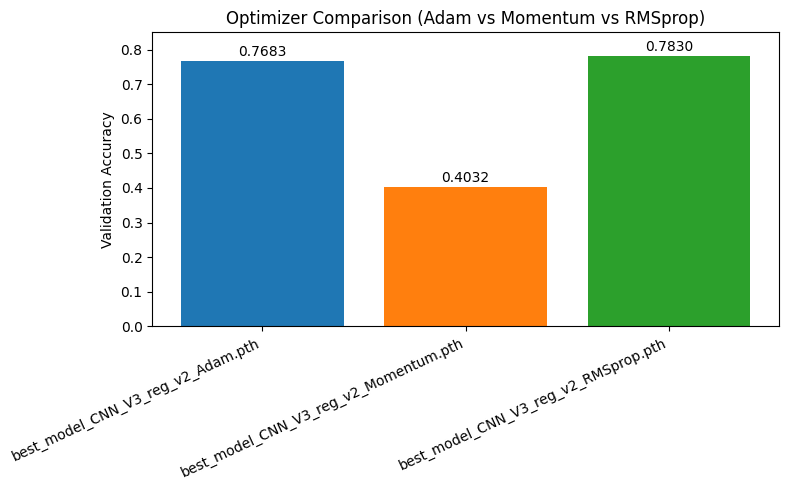

In [21]:
# Convert your results list/dict to DataFrame
results_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)

# 1️⃣ Optimizer models
optimizer_models = [
    "best_model_CNN_V3_reg_v2_Adam.pth",
    "best_model_CNN_V3_reg_v2_Momentum.pth",
    "best_model_CNN_V3_reg_v2_RMSprop.pth"
]

optimizer_df = results_df[results_df["model_name"].isin(optimizer_models)].copy()

# Sort to keep a nice order (optional)
optimizer_df["model_name"] = pd.Categorical(
    optimizer_df["model_name"], 
    categories=optimizer_models, 
    ordered=True
)
optimizer_df = optimizer_df.sort_values("model_name")

# 🟦 Plot Optimizer comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(optimizer_df["model_name"], optimizer_df["accuracy"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.4f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xticks(rotation=25, ha="right")
plt.ylabel("Validation Accuracy")
plt.ylim([0, 0.85])
plt.title("Optimizer Comparison (Adam vs Momentum vs RMSprop)")
plt.tight_layout()
plt.show()



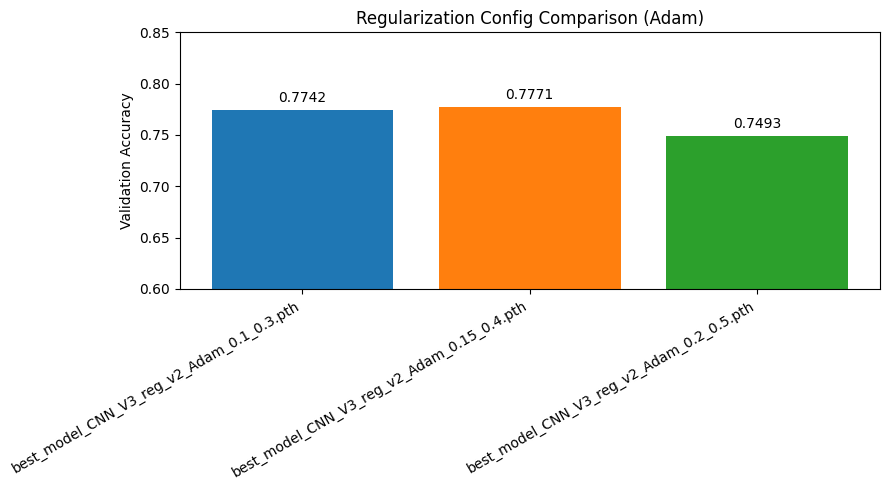

In [24]:
# 2️⃣ Regularization models (Adam with different p_conv/p_fc)
reg_models = [
    "best_model_CNN_V3_reg_v2_Adam_0.1_0.3.pth",
    "best_model_CNN_V3_reg_v2_Adam_0.15_0.4.pth",
    "best_model_CNN_V3_reg_v2_Adam_0.2_0.5.pth"
]

reg_df = results_df[results_df["model_name"].isin(reg_models)].copy()

# Optional: order by config
reg_df["model_name"] = pd.Categorical(
    reg_df["model_name"], 
    categories=reg_models, 
    ordered=True
)
reg_df = reg_df.sort_values("model_name")

# 🟪 Plot Regularization configs comparison
plt.figure(figsize=(9, 5))
bars = plt.bar(reg_df["model_name"], reg_df["accuracy"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.4f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xticks(rotation=30, ha="right")
plt.ylabel("Validation Accuracy")
plt.ylim([0.6, 0.85])
plt.title("Regularization Config Comparison (Adam)")
plt.tight_layout()
plt.show()
